In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import xarray as xr
import glob
import datetime as dt
import tqdm
from matplotlib.patches import Rectangle
import pytz
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from sklearn.metrics import roc_curve, RocCurveDisplay
from matplotlib.lines import Line2D


## This notebook will contain all analysis that compares events with nulls

In [2]:
def load_scws(rid,tz):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,2:1,1:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1 = add_lt(df1,tz)    
    df1["year"] = df1.index.year
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    df1["rid"] = rid  
    df1["scw"] = 1
    
    return df1

def load_nulls(rid,tz):
    
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    
    df2["cluster_new"] = df2.cluster.map({0:2,2:1,1:0})
    df2 = df2.set_index(pd.DatetimeIndex(df2.dt_utc))
    df2 = add_lt(df2,tz)    
    df2["year"] = df2.index.year
    df2["month"] = df2.index.month
    df2["hour"] = df2["lt"].dt.hour
    df2["rid"] = rid   
    df2["scw"] = 0
    
    return df2

def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def remove_suspect_gusts(df):
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]

def assign_storm_class(data):

    #Linear
    data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
    #Non-linear
    data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
    #Cellular
    data.loc[(data.local_max == 1),"class2"] = "Cellular"
    #Cluster of cells
    data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
    #Supercell
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
    #Linear hybrid
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"
    
    return data

In [3]:
tzs = {"68":'Australia/Melbourne',
       "64":'Australia/Adelaide',
       "8":'Australia/Brisbane',
       "72":'Australia/Queensland',
       "75":'Australia/Queensland',
       "19":'Australia/Queensland',
       "73":'Australia/Queensland',
       "78":'Australia/Queensland',
       "77":'Australia/Darwin',
       "49":'Australia/Victoria',
       "4":'Australia/Sydney',
       "40":'Australia/Canberra',
       "48":'Australia/West',
       "2":'Australia/Melbourne',
       "66":'Australia/Brisbane',
       "69":'Australia/NSW',
       "70":'Australia/Perth',
       "71":'Australia/Sydney',
      "63":'Australia/Darwin',
      "76":'Australia/Hobart',
      "77":"Australia/Darwin"}
       
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
df = pd.DataFrame()
for rid in rids:
    df = pd.concat([df,remove_suspect_gusts(load_scws(rid,tzs[rid]))],axis=0)
    df = pd.concat([df,load_nulls(rid,tzs[rid])],axis=0)    

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...
loading 64...
loading 8...
loading 72...
loading 75...
loading 19...
loading 73...
loading 78...
loading 49...
loading 4...
loading 40...
loading 48...
loading 68...
loading 63...
loading 76...
loading 77...


In [4]:
#Do some logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(class_weight="balanced", solver="liblinear",max_iter=1000)

In [6]:
preds = ["ebwd","lr03","dpd700","Umean06","ml_cape","lr13"]
logit_mod = logit.fit(df[preds], df["scw"])
print("All clusters\n")
pd.DataFrame({"preds":preds,"coefs":logit_mod.coef_.squeeze()})

All clusters



,preds,coefs
0,ebwd,0.101661
1,lr03,0.635822
2,dpd700,-0.204226
3,Umean06,0.183082
4,ml_cape,0.001681
5,lr13,0.340770


In [7]:
preds = ["Umean03","sb_el","rhmin13","lr24","U10"]
logit_mod = logit.fit(df[preds+["cluster_new"]].query("cluster_new==0")[preds], df[["cluster_new","scw"]].query("cluster_new==0")["scw"])
print("Strong background wind cluster\n")
pd.DataFrame({"preds":preds,"coefs":logit_mod.coef_.squeeze()})

Strong background wind cluster



,preds,coefs
0,Umean03,0.259088
1,sb_el,0.000559
2,rhmin13,0.055081
3,lr24,0.902474
4,U10,0.402405


In [8]:
preds = ["Uwindinf","lr13","pwat","U10","rhmin13","ml_cin","ebwd"]
logit_mod = logit.fit(df[preds+["cluster_new"]].query("cluster_new==1")[preds], df[["cluster_new","scw"]].query("cluster_new==1")["scw"])
print("Steep lapse rate cluster\n")
pd.DataFrame({"preds":preds,"coefs":logit_mod.coef_.squeeze()})

Steep lapse rate cluster



,preds,coefs
0,Uwindinf,0.124620
1,lr13,1.988074
2,pwat,2.870036
3,U10,0.399860
4,rhmin13,0.044944
5,ml_cin,-0.007595
6,ebwd,0.084358


In [9]:
preds = ["srhe_left","lr03","rhmin03","rhmin01","srh03_left"]
logit_mod = logit.fit(df[preds+["cluster_new"]].query("cluster_new==2")[preds], df[["cluster_new","scw"]].query("cluster_new==2")["scw"])
print("High moisture\n")
pd.DataFrame({"preds":preds,"coefs":logit_mod.coef_.squeeze()})

High moisture



,preds,coefs
0,srhe_left,0.034587
1,lr03,0.783530
2,rhmin03,0.099229
3,rhmin01,-0.072791
4,srh03_left,-0.005475


In [10]:
#Check the proportion of data (SCWs, convective nulls), that don't have azimuthal shear data.

print("% of SCW events w/o azi shear data: ",(df[["scw","azi_shear"]].query("scw==1").azi_shear.isnull().sum() / df.scw.sum()) * 100)

print("% of convective nulls w/o azi shear data: ",
      (df[["scw","in10km","azi_shear"]].query("(scw==0) & (in10km==1)").azi_shear.isnull().sum() / (df.in10km.sum()-df.scw.sum())) * 100)

% of SCW events w/o azi shear data:  4.358353510895883
% of convective nulls w/o azi shear data:  6.484249342142369


In [11]:
tropical_rids=["63","72","75","19","73","78",'77']
east_coast_rids=["4","8","66","71"]
inland_rids=["48","49","69"]
south_coast_rids=["70","2","68","64","76","40"]

/jobfs/78640385.gadi-pbs/ipykernel_58523/3907266313.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null["hour"] = pd.to_datetime(df_null.dt_lt,format="%Y%m%d%H%M").dt.hour


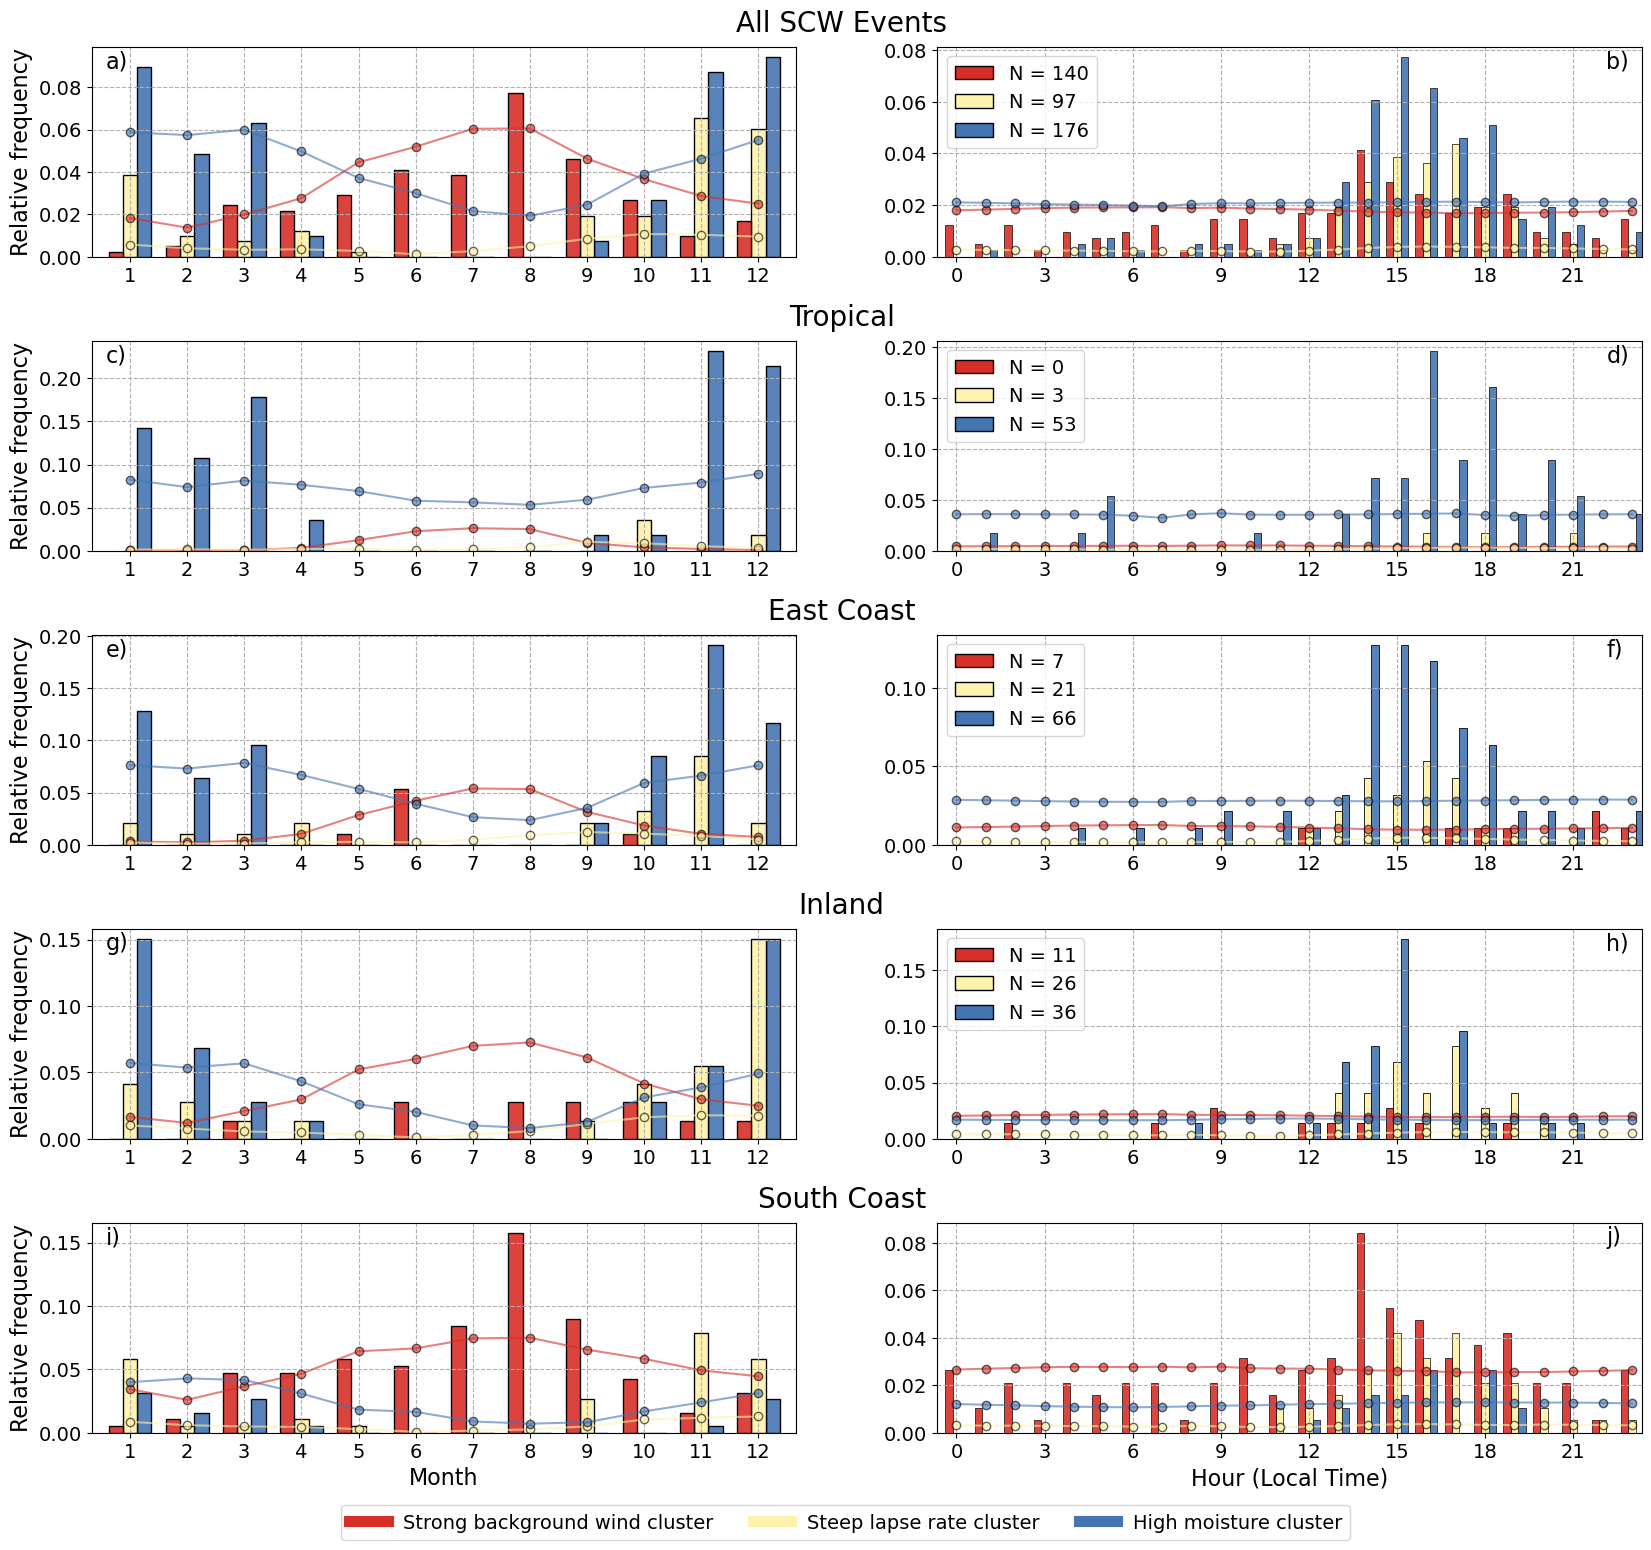

In [12]:
def plot_hist_seasonal(df,ax,ymax2=None,title="",letter=""):
    sns.histplot(x="month",data=df,
             discrete=True,hue="cluster_new",multiple="dodge",palette=p, legend=False, stat="probability", kde=False, alpha=0.9,
            line_kws={"lw":3},common_norm=True,hue_order=[0,1,2],ax=ax,shrink=0.75)

    ax.grid(ls="--")
    ax.set_ylim([0,ymax2])    
    ax.set_xlabel("")
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xlim([0.33,12.66])
    ax.yaxis.label.set_size(16)
    ax.tick_params("both",labelsize=14)
    ax.text(0.02,0.9,letter+")",size=16,transform=ax.transAxes)    
    plt.gcf().text(0.5,ax.get_position().y1+0.005,title,ha="center",va="bottom",size=20)
    
def plot_hist_diurnal(df,ax,ymax2=None,letter=""):
    
    df["hour"] = pd.to_datetime(df.dt_lt,format="%Y%m%d%H%M").dt.hour
    
    sns.histplot(x="hour",data=df,
             discrete=True,hue="cluster_new",multiple="dodge",palette=p, legend=False, stat="probability", kde=False, alpha=0.9,
            line_kws={"lw":3},common_norm=True,hue_order=[0,1,2],ax=ax,shrink=0.75)
    plt.xlim([-0.5,23.5])
    ax.grid(ls="--")
    ax.set_ylim([0,ymax2])    
    ax.set_xlabel("")
    ax.set_xticks(np.arange(0,24,3))
    ax.set_xlim([-0.66,23.33])
    ax.yaxis.label.set_size(16)
    ax.tick_params("both",labelsize=14)    
    ax.set_ylabel("")
    ax.text(0.95,0.9,letter+")",size=16,transform=ax.transAxes)    
    create_legend(ax, p, ["N = "+str((df.cluster_new==i).sum()) for i in np.arange(3)])
    
def plot_bg_prob_seasonal(df_null,ax1):
#    ax1=ax.twinx()
    counts = df_null.groupby(["cluster_new","month"]).agg("size")
    counts = counts / df_null.shape[0]
    ax1.plot(counts.loc[0],color=p[0],marker="o",mec="k",alpha=0.6)
    ax1.plot(counts.loc[1],color=p[1],marker="o",mec="k",alpha=0.6)
    ax1.plot(counts.loc[2],color=p[2],marker="o",mec="k",alpha=0.6)
    ax1.set_ylabel("Relative frequency")
    
def plot_bg_prob_diurnal(df_null,ax):
#    ax1=ax.twinx()

    df_null["hour"] = pd.to_datetime(df_null.dt_lt,format="%Y%m%d%H%M").dt.hour
    
    counts = df_null.groupby(["cluster_new","hour"]).agg("size")
    counts = counts / df_null.shape[0]
    ax.plot(counts.loc[0],color=p[0],marker="o",mec="k",alpha=0.6)
    ax.plot(counts.loc[1],color=p[1],marker="o",mec="k",alpha=0.6)
    ax.plot(counts.loc[2],color=p[2],marker="o",mec="k",alpha=0.6)

def create_legend(ax,p,labels):

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in p]
    plt.legend(handles, labels, loc="upper left",fontsize=14)
    

plt.figure(figsize=[20,18])
p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
plt.subplots_adjust(hspace=0.4)

plot_hist_seasonal(df[df["scw"]==1].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,1),ymax2=None,title="All SCW Events",letter="a")
plot_bg_prob_seasonal(df[["rid","month","cluster_new","scw"]],plt.subplot(5,2,1))

plot_hist_seasonal(df[(np.in1d(df.rid,tropical_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,3),title="Tropical",letter="c")
plot_bg_prob_seasonal(df[["rid","month","cluster_new","scw"]][(np.in1d(df.rid,tropical_rids)) & (df.scw==0)],plt.subplot(5,2,3))

plot_hist_seasonal(df[(np.in1d(df.rid,east_coast_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,5),title="East Coast",letter="e")
plot_bg_prob_seasonal(df[["rid","month","cluster_new","scw"]][(np.in1d(df.rid,east_coast_rids)) & (df.scw==0)],plt.subplot(5,2,5))

plot_hist_seasonal(df[(np.in1d(df.rid,inland_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,7),title="Inland",letter="g")
plot_bg_prob_seasonal(df[["rid","month","cluster_new","scw"]][(np.in1d(df.rid,inland_rids)) & (df.scw==0)],plt.subplot(5,2,7))

plot_hist_seasonal(df[(np.in1d(df.rid,south_coast_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,9),title="South Coast",letter="i")
plot_bg_prob_seasonal(df[["rid","month","cluster_new","scw"]][(np.in1d(df.rid,south_coast_rids)) & (df.scw==0)],plt.subplot(5,2,9))
plt.gca().set_xlabel("Month",size=16)


plot_hist_diurnal(df[df["scw"]==1].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,2),ymax2=None,letter="b")
plot_bg_prob_diurnal(df[["rid","dt_lt","cluster_new","scw"]],plt.subplot(5,2,2))

plot_hist_diurnal(df[(np.in1d(df.rid,tropical_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,4),letter="d")
plot_bg_prob_diurnal(df[["rid","dt_lt","cluster_new","scw"]][(np.in1d(df.rid,tropical_rids)) & (df.scw==0)],plt.subplot(5,2,4))

plot_hist_diurnal(df[(np.in1d(df.rid,east_coast_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,6),letter="f")
plot_bg_prob_diurnal(df[["rid","dt_lt","cluster_new","scw"]][(np.in1d(df.rid,east_coast_rids)) & (df.scw==0)],plt.subplot(5,2,6))

plot_hist_diurnal(df[(np.in1d(df.rid,inland_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,8),letter="h")
plot_bg_prob_diurnal(df[["rid","dt_lt","cluster_new","scw"]][(np.in1d(df.rid,inland_rids)) & (df.scw==0)],plt.subplot(5,2,8))

plot_hist_diurnal(df[(np.in1d(df.rid,south_coast_rids)) & (df["scw"]==1)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,10),letter="j")
plot_bg_prob_diurnal(df[["rid","dt_lt","cluster_new","scw"]][(np.in1d(df.rid,south_coast_rids)) & (df.scw==0)],plt.subplot(5,2,10))
plt.gca().set_xlabel("Hour (Local Time)",size=16)

custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=14,ncol=3,bbox_to_anchor=(0.1,-0.4,0.5,0.1)) 

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_temporal_hist.jpeg",dpi=1000,bbox_inches="tight")

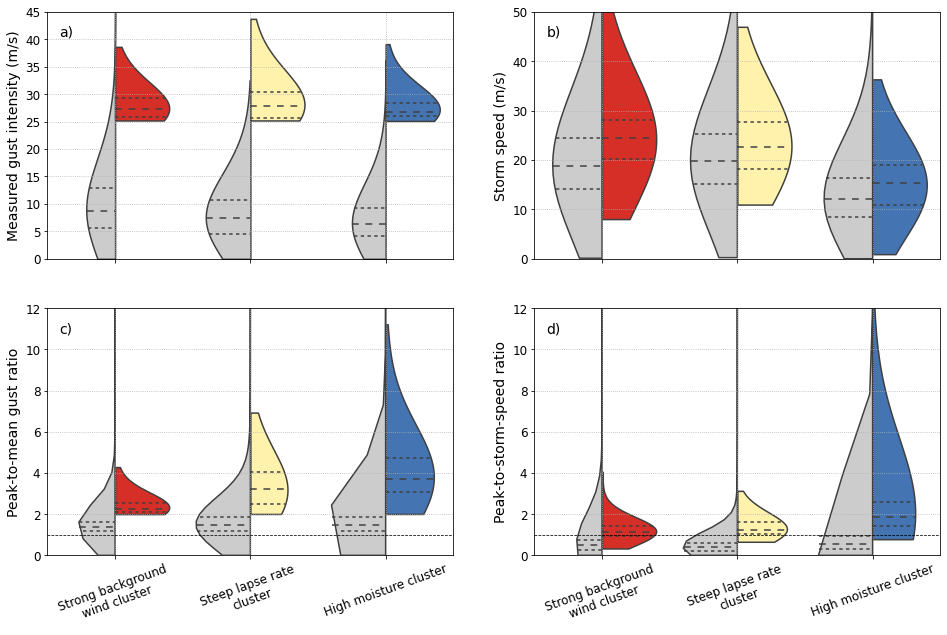

In [13]:
plt.figure(figsize=[16,10])
df["wgr_sherb"] = df["gust"] / df["speed"]

v0 = [0,0,0,0]
v1 = [45,50,12,12]
labels = ["Measured gust intensity (m/s)","Storm speed (m/s)","Peak-to-mean gust ratio","Peak-to-storm-speed ratio"]
letter = ["a","b","c","d"]
cnt=0
for v in ["gust","speed","wgr_4","wgr_sherb"]:

    plt.subplot(2,2,cnt+1)
    
    sns.violinplot(data=df[["in10km","cluster_new","scw","gust","speed","wgr_4","wgr_sherb"]].query("in10km==1"),
                   y=v,x="cluster_new",inner="quartile",hue="scw",split=True,bw=1.5,cut=0)
    ax=plt.gca()
    colors = p
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 1:
            rgb = [0.8,0.8,0.8] 
        violin.set_facecolor(rgb)

    plt.gca().grid(ls=":")
    plt.gca().set_ylim([v0[cnt],v1[cnt]])
    
    if v in ["wgr_4","wgr_sherb"]:
        plt.gca().axhline(1,ls="--",color="k",lw=0.75)
    plt.ylabel(labels[cnt],size=14)
    plt.gca().tick_params(labelsize=12)
    plt.gca().legend_.remove()
    if cnt>=2:
        plt.xticks([0,1,2],["Strong background\nwind cluster","Steep lapse rate\ncluster","High moisture cluster"],rotation=20,size=12)
    else:
        plt.xticks([0,1,2],["","",""])
    plt.xlabel("")
    
    ax.text(0.03,0.9,letter[cnt]+")",size=14,transform=ax.transAxes)
    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/obs_stats.jpeg",dpi=400,bbox_inches="tight")

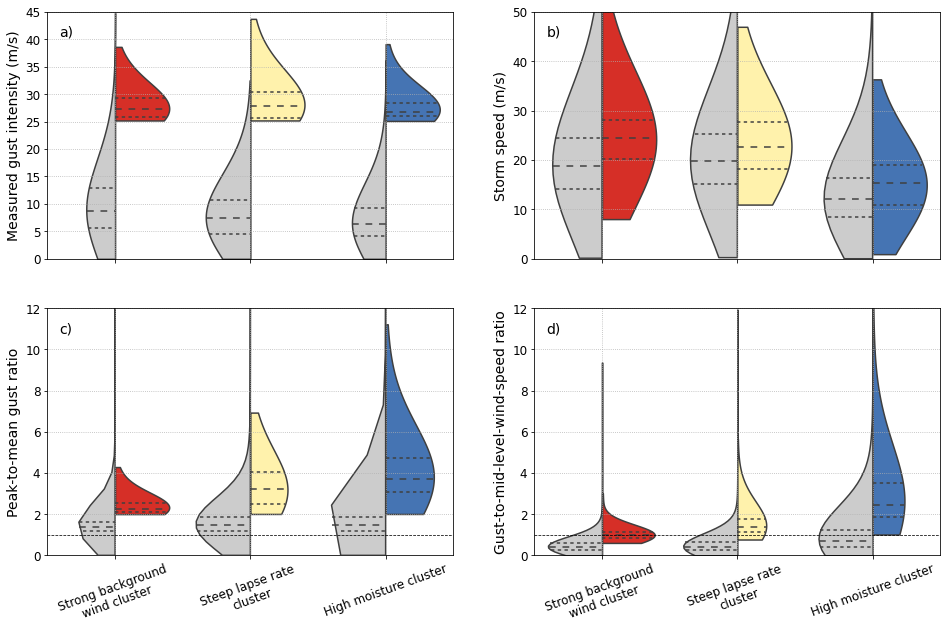

In [14]:
plt.figure(figsize=[16,10])
df["gust_to_umean"] = df["gust"] / df["Umean800_600"]

v0 = [0,0,0,0]
v1 = [45,50,12,12]
labels = ["Measured gust intensity (m/s)","Storm speed (m/s)","Peak-to-mean gust ratio","Gust-to-mid-level-wind-speed ratio"]
letter = ["a","b","c","d"]
cnt=0
for v in ["gust","speed","wgr_4","gust_to_umean"]:

    plt.subplot(2,2,cnt+1)
    
    sns.violinplot(data=df[["in10km","cluster_new","scw","gust","speed","wgr_4","gust_to_umean"]].query("in10km==1"),
                   y=v,x="cluster_new",inner="quartile",hue="scw",split=True,bw=1.5,cut=0)
    ax=plt.gca()
    colors = p
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 1:
            rgb = [0.8,0.8,0.8] 
        violin.set_facecolor(rgb)

    plt.gca().grid(ls=":")
    plt.gca().set_ylim([v0[cnt],v1[cnt]])
    
    if v in ["wgr_4","gust_to_umean"]:
        plt.gca().axhline(1,ls="--",color="k",lw=0.75)
    plt.ylabel(labels[cnt],size=14)
    plt.gca().tick_params(labelsize=12)
    plt.gca().legend_.remove()
    if cnt>=2:
        plt.xticks([0,1,2],["Strong background\nwind cluster","Steep lapse rate\ncluster","High moisture cluster"],rotation=20,size=12)
    else:
        plt.xticks([0,1,2],["","",""])
    plt.xlabel("")
    
    ax.text(0.03,0.9,letter[cnt]+")",size=14,transform=ax.transAxes)
    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/obs_stats2.jpeg",dpi=400,bbox_inches="tight")

In [15]:
df[["scw","cluster_new","wgr_sherb"]].query("(scw==1) & (cluster_new==0)").quantile([0.25,0.5,0.75])

,scw,cluster_new,wgr_sherb
0.25,1.0,0.0,0.959306
0.50,1.0,0.0,1.154866
0.75,1.0,0.0,1.403067


In [16]:
df[["scw","cluster_new","wgr_sherb"]].query("(scw==1) & (cluster_new==1)").quantile([0.25,0.5,0.75])

,scw,cluster_new,wgr_sherb
0.25,1.0,1.0,1.045729
0.50,1.0,1.0,1.218356
0.75,1.0,1.0,1.622909


In [17]:
df[["scw","cluster_new","wgr_sherb"]].query("(scw==1) & (cluster_new==2)").quantile([0.25,0.5,0.75])

,scw,cluster_new,wgr_sherb
0.25,1.0,2.0,1.448304
0.50,1.0,2.0,1.884525
0.75,1.0,2.0,2.611537


In [18]:
df[["scw","cluster_new","gust_to_umean"]].query("(scw==1) & (cluster_new==0)").quantile([0.25,0.5,0.75])

,scw,cluster_new,gust_to_umean
0.25,1.0,0.0,0.859225
0.50,1.0,0.0,0.979103
0.75,1.0,0.0,1.122413


In [19]:
df[["scw","cluster_new","gust_to_umean"]].query("(scw==1) & (cluster_new==1)").quantile([0.25,0.5,0.75])

,scw,cluster_new,gust_to_umean
0.25,1.0,1.0,1.144786
0.50,1.0,1.0,1.382530
0.75,1.0,1.0,1.750320


In [20]:
df[["scw","cluster_new","gust_to_umean"]].query("(scw==1) & (cluster_new==2)").quantile([0.25,0.5,0.75])

,scw,cluster_new,gust_to_umean
0.25,1.0,2.0,1.842671
0.50,1.0,2.0,2.450661
0.75,1.0,2.0,3.508967


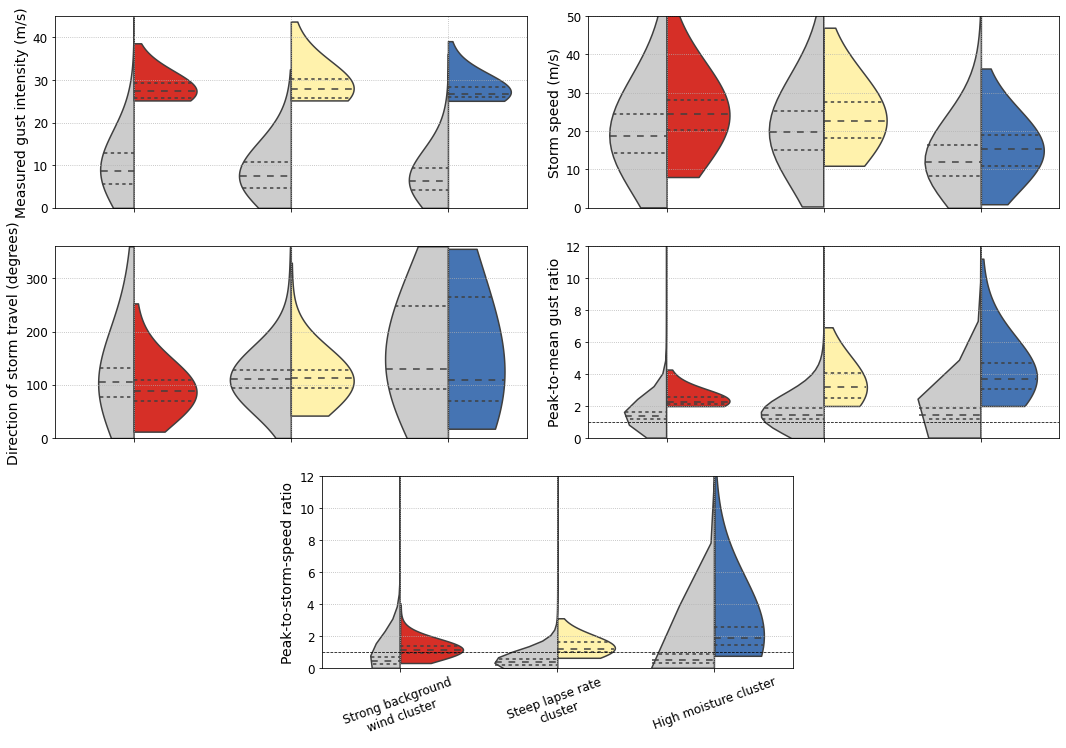

In [21]:
plt.figure(figsize=[18,12])
df["wgr_sherb"] = df["gust"] / df["speed"]

v0 = [0,0,0,0,0]
v1 = [45,50,360,12,12]
labels = ["Measured gust intensity (m/s)","Storm speed (m/s)","Direction of storm travel (degrees)","Peak-to-mean gust ratio","Peak-to-storm-speed ratio"]

cnt=0
shape=(3,4)
locs={"gust":(0,0),"speed":(0,2),"angle":(1,0),"wgr_4":(1,2),"wgr_sherb":(2,1)}
colspans=2
for v in ["gust","speed","angle","wgr_4","wgr_sherb"]:

    #plt.subplot(2,2,cnt+1)
    plt.subplot2grid(shape,locs[v],colspan=colspans)
    sns.violinplot(data=df[["in10km","cluster_new","scw","gust","speed","wgr_4","wgr_sherb","angle"]].query("in10km==1"),
                   y=v,x="cluster_new",cut=0,inner="quartile",hue="scw",split=True,bw=1.5)
    ax=plt.gca()
    colors = p
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 1:
            rgb = [0.8,0.8,0.8] 
        violin.set_facecolor(rgb)

    plt.gca().grid(ls=":")
    plt.gca().set_ylim([v0[cnt],v1[cnt]])
    
    if v in ["wgr_4","wgr_sherb"]:
        plt.gca().axhline(1,ls="--",color="k",lw=0.75)
    plt.ylabel(labels[cnt],size=14)
    plt.gca().tick_params(labelsize=12)
    plt.gca().legend_.remove()
    if cnt>=4:
        plt.xticks([0,1,2],["Strong background\nwind cluster","Steep lapse rate\ncluster","High moisture cluster"],rotation=20,size=12)
    else:
        plt.xticks([0,1,2],["","",""])
    plt.xlabel("")
    
    cnt=cnt+1
    
plt.subplots_adjust(wspace=0.3)

In [22]:
df["aspect_ratio"] = df.major_axis_length / df.minor_axis_length     
df = assign_storm_class(df)

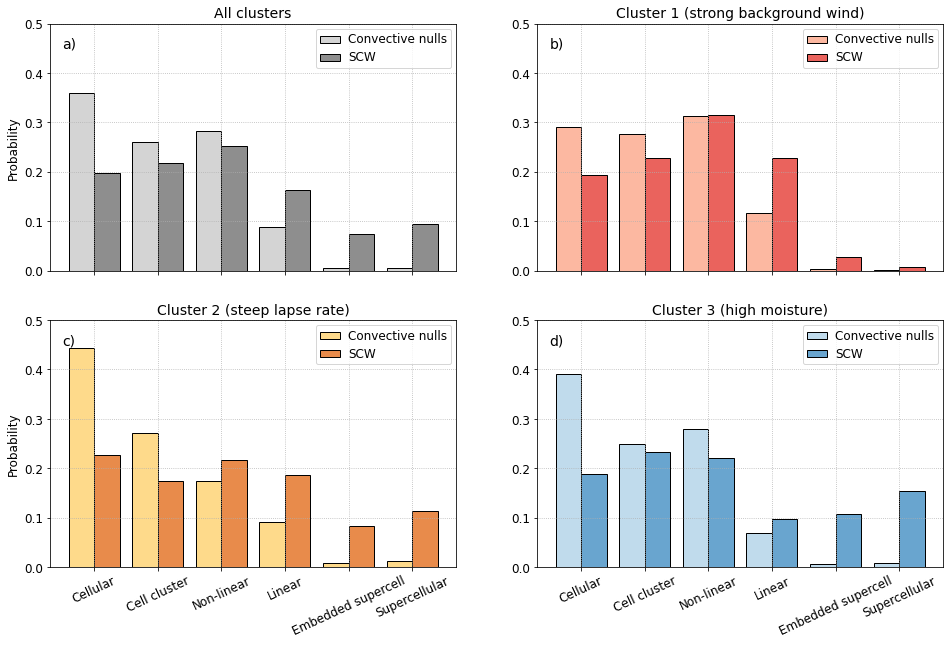

In [23]:
order = ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]
df["class3"] = df.class2.map(dict(zip(order, np.arange(len(order)))))

plt.figure(figsize=[16,10])

ax=plt.subplot(2,2,1)
h=sns.histplot(df[["in10km","class3","scw"]].query("in10km==1").reset_index(),x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Greys")
ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0,0.5]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("All clusters",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("Probability",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Convective nulls", "SCW")):
    t.set_text(l)
ax.text(0.03,0.9,"a)",size=14,transform=ax.transAxes)
    
ax=plt.subplot(2,2,2)
h=sns.histplot(df[["in10km","class3","scw","cluster_new"]].query("(in10km==1) & (cluster_new==0)").reset_index(),x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Reds")
ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0,0.5]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 1 (strong background wind)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Convective nulls", "SCW")):
    t.set_text(l)
ax.text(0.03,0.9,"b)",size=14,transform=ax.transAxes)

ax=plt.subplot(2,2,3)
h=sns.histplot(df[["in10km","class3","scw","cluster_new"]].query("(in10km==1) & (cluster_new==1)").reset_index(),x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="YlOrBr")
ax.set_xticks(np.arange(len(order)),labels=order); ax.set_ylim([0,0.5]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 2 (steep lapse rate)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("Probability",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Convective nulls", "SCW")):
    t.set_text(l)
ax.text(0.03,0.9,"c)",size=14,transform=ax.transAxes)

ax=plt.subplot(2,2,4)
h=sns.histplot(df[["in10km","class3","scw","cluster_new"]].query("(in10km==1) & (cluster_new==2)").reset_index(),x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Blues")
ax.set_xticks(np.arange(len(order)),labels=order); ax.set_ylim([0,0.5]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 3 (high moisture)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Convective nulls", "SCW")):
    t.set_text(l)
ax.text(0.03,0.9,"d)",size=14,transform=ax.transAxes)
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/storm_class_dist.jpeg",dpi=400,bbox_inches="tight")    

In [24]:
output = {"all":[],0:[],1:[],2:[]}

print("All clusters")
for c in np.arange(len(order)):
    temp = df[["in10km","class3","scw","cluster_new"]].query("(in10km==1) & (class3=="+str(c)+")")
    #print(order[c], temp.scw.sum() / temp.shape[0] * 100)
    output["all"].append(temp.scw.sum() / temp.shape[0] * 100)

for clust in [0,1,2]:
    print("\nCluster "+str(clust+1))
    for c in np.arange(len(order)):
        temp = df[["in10km","class3","scw","cluster_new"]].query("(in10km==1) & (class3=="+str(c)+") & (cluster_new=="+str(clust)+")")
        #print(order[c], temp.scw.sum() / temp.shape[0] * 100)
        output[clust].append(temp.scw.sum() / temp.shape[0] * 100)

All clusters

Cluster 1

Cluster 2

Cluster 3


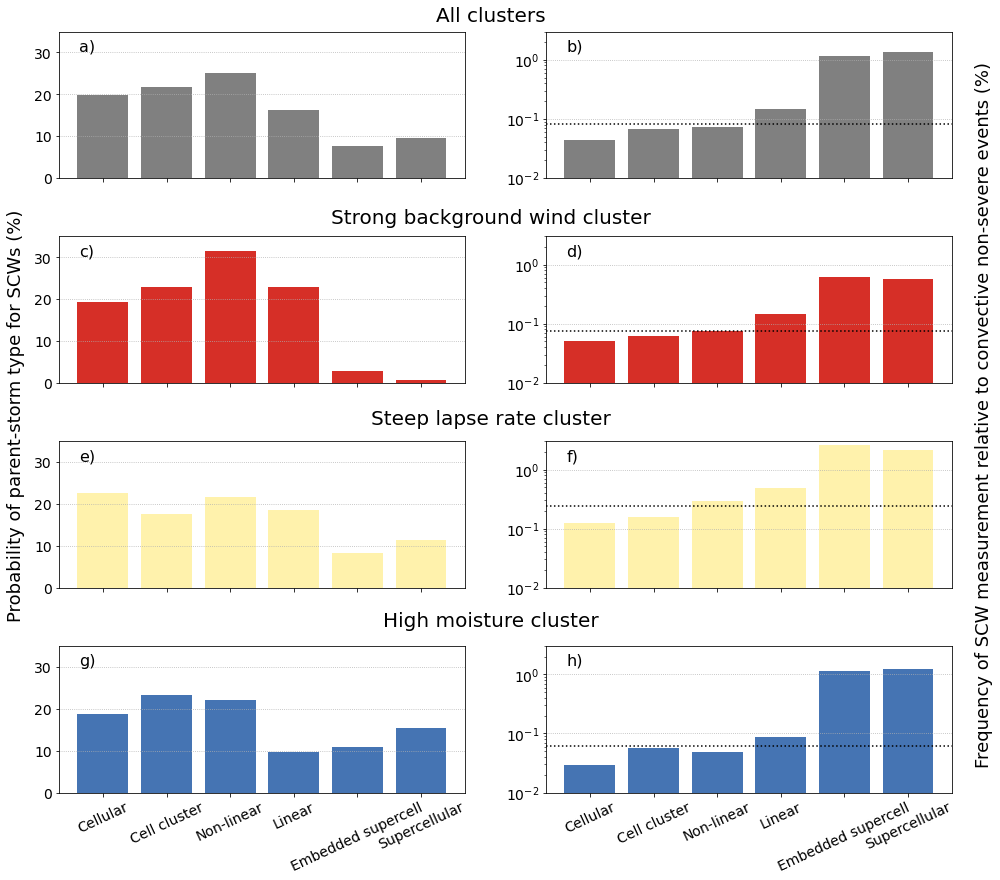

In [25]:
def plot_storm_types(output,df,ax1,ax2,cluster,p,letters):

    if cluster=="all":
        ax=ax1
        ax.bar(x=np.arange(0,len(order)),
               height=[df[df["class3"]==i][["scw","cluster_new"]].query("(scw==1)").shape[0] for i in np.arange(len(order))] / df.scw.sum() * 100,
               color="grey",alpha=1)
        ax.set_xticks(np.arange(len(order)),labels=""); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")
        ax.set_ylim([0,35])
        ax.tick_params(labelsize=14) 
        ax.text(0.05,0.87,letters[0],size=16,transform=ax.transAxes)        
        
        ax=ax2
        ax.bar(x=np.arange(0,len(order)),height=output["all"],color="gray",alpha=1)
        ax.set_yscale("log")
        ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0.01,3]); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")
        ax.yaxis.set_label_position("right")
        ax.axhline(df.scw.sum() / df.query("in10km==1").shape[0] * 100, color="k", ls=":")
        ax.tick_params(labelsize=14)
        ax.text(0.05,0.87,letters[1],size=16,transform=ax.transAxes)
        
        
    else:
        ax=ax1
        ax.bar(x=np.arange(0,len(order)),
               height=[df[df["class3"]==i][["scw","cluster_new"]].query("(scw==1) & (cluster_new=="+str(cluster)+")").shape[0] for i in np.arange(len(order))] / df[df.cluster_new==cluster].scw.sum() * 100,
               color=p[cluster])
        if cluster==2:
            ax.set_xticks(np.arange(len(order)),labels=order); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")
        else:
            ax.set_xticks(np.arange(len(order)),labels=""); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")
        ax.set_ylim([0,35])
        ax.tick_params(labelsize=14)  
        ax.text(0.05,0.87,letters[0],size=16,transform=ax.transAxes)        
        
        ax=ax2
        ax.bar(x=np.arange(0,len(order)),height=output[cluster],color=p[cluster],alpha=1)
        ax.set_yscale("log")
        ax.yaxis.set_label_position("right")
        ax.axhline(df.query("(cluster_new=="+str(cluster)+")").scw.sum() / df.query("(in10km==1) & (cluster_new=="+str(cluster)+")").shape[0] * 100, 
                   color="k", ls=":")        
        if cluster==2:
            ax.set_xticks(np.arange(len(order)),labels=order); ax.set_ylim([0.01,3]); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")        
        else:
            ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0.01,3]); ax.tick_params(axis="x",rotation=25); ax.grid(axis="y",ls=":")                    
        ax.tick_params(labelsize=14)   
        ax.text(0.05,0.87,letters[1],size=16,transform=ax.transAxes)        
        
fig=plt.figure(figsize=[16,14])
plot_storm_types(output,df,plt.subplot(4,2,1),plt.subplot(4,2,2),"all",p,["a)","b)"])
plot_storm_types(output,df,plt.subplot(4,2,3),plt.subplot(4,2,4),0,p,["c)","d)"])
plot_storm_types(output,df,plt.subplot(4,2,5),plt.subplot(4,2,6),1,p,["e)","f)"])
plot_storm_types(output,df,plt.subplot(4,2,7),plt.subplot(4,2,8),2,p,["g)","h)"])
fig.text(0.08,0.5,"Probability of parent-storm type for SCWs (%)",va="center",rotation=90,size=18)
fig.text(0.92,0.5,"Frequency of SCW measurement relative to convective non-severe events (%)",va="center",rotation=90,size=18)
fig.text(0.5,0.89,"All clusters",size=20,ha="center")
fig.text(0.5,0.69,"Strong background wind cluster",size=20,ha="center")
fig.text(0.5,0.49,"Steep lapse rate cluster",size=20,ha="center")
fig.text(0.5,0.29,"High moisture cluster",size=20,ha="center")
plt.subplots_adjust(hspace=0.4)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/storm_class_dist2.jpeg",dpi=400,bbox_inches="tight")    

In [26]:
print("\nAll clusters (SCWs)")
print(np.round(df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1)").value_counts("class2") / (df.scw.sum()) * 100,2))

print("\nStrong background wind")
print(np.round(df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==0)").value_counts("class2") /\
         (df[["scw","cluster_new"]].query("(cluster_new==0)").scw.sum()) * 100,2))

print("\nSteep lapse rate")
print(np.round(df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==1)").value_counts("class2") /\
         (df[["scw","cluster_new"]].query("(cluster_new==1)").scw.sum()) * 100,2))

print("\nHigh moisture")
print(np.round(df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==2)").value_counts("class2") /\
         (df[["scw","cluster_new"]].query("(cluster_new==2)").scw.sum()) * 100,2))


All clusters (SCWs)
class2
Non-linear            25.18
Cell cluster          21.79
Cellular              19.85
Linear                16.22
Supercellular          9.44
Embedded supercell     7.51
dtype: float64

Strong background wind
class2
Non-linear            31.43
Cell cluster          22.86
Linear                22.86
Cellular              19.29
Embedded supercell     2.86
Supercellular          0.71
dtype: float64

Steep lapse rate
class2
Cellular              22.68
Non-linear            21.65
Linear                18.56
Cell cluster          17.53
Supercellular         11.34
Embedded supercell     8.25
dtype: float64

High moisture
class2
Cell cluster          23.30
Non-linear            22.16
Cellular              18.75
Supercellular         15.34
Embedded supercell    10.80
Linear                 9.66
dtype: float64


In [27]:
print("Conditional probs\n")

print("\nAll clusters (SCWs)")
print(np.round((df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1)").value_counts("class2") /\
df[["class2","cluster_new","scw","in10km"]].query("(scw==0) & (in10km==1)").value_counts("class2")) * 100, 2))

print("\nStrong background wind (SCWs)")
print(np.round((df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==0)").value_counts("class2") /\
df[["class2","cluster_new","scw","in10km"]].query("(scw==0) & (in10km==1) & (cluster_new==0)").value_counts("class2")) * 100, 2))

print("\nSteep lapse rate (SCWs)")
print(np.round((df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==1)").value_counts("class2") /\
df[["class2","cluster_new","scw","in10km"]].query("(scw==0) & (in10km==1) & (cluster_new==1)").value_counts("class2")) * 100, 2))

print("\nHigh moisture (SCWs)")
print(np.round((df[["class2","cluster_new","scw","in10km"]].query("(scw==1) & (in10km==1) & (cluster_new==2)").value_counts("class2") /\
df[["class2","cluster_new","scw","in10km"]].query("(scw==0) & (in10km==1) & (cluster_new==2)").value_counts("class2")) * 100, 2))

Conditional probs


All clusters (SCWs)
class2
Cell cluster          0.07
Cellular              0.04
Embedded supercell    1.19
Linear                0.15
Non-linear            0.07
Supercellular         1.40
dtype: float64

Strong background wind (SCWs)
class2
Cell cluster          0.06
Cellular              0.05
Embedded supercell    0.62
Linear                0.15
Non-linear            0.08
Supercellular         0.58
dtype: float64

Steep lapse rate (SCWs)
class2
Cell cluster          0.15
Cellular              0.12
Embedded supercell    2.68
Linear                0.48
Non-linear            0.30
Supercellular         2.23
dtype: float64

High moisture (SCWs)
class2
Cell cluster          0.06
Cellular              0.03
Embedded supercell    1.15
Linear                0.09
Non-linear            0.05
Supercellular         1.27
dtype: float64


In [28]:
  def plot_violin_split(data, v, cluster, order, ax, title=False, label=False, sample_size="top",legend=False):

    ys = {"s06":"linear","qmean01":"linear","Umean06":"linear","lr13":"linear","s01":"linear","ebwd":"linear","s03":"linear",
         "mu_cape":"linear","dcape":"linear","mu_lcl":"linear","ml_lcl":"linear","bdsd":"linear","convgust_dry":"linear","gustex":"linear","wg10":"linear"}
    vmin = {"s06":0,"qmean01":2.5,"lr13":1,"Umean06":0,"s01":0,"ebwd":0,"s03":0,"mu_cape":0,"dcape":0,"mu_lcl":0,"ml_lcl":0,"bdsd":0,"convgust_dry":0,"gustex":0,"wg10":0}
    vmax = {"s06":None,"qmean01":22,"lr13":12,"Umean06":45,"s01":40,"ebwd":60,"s03":60,"mu_cape":5000,"dcape":2500,"mu_lcl":5000,"ml_lcl":6000,"bdsd":1,"gustex":100,
           "convgust_dry":100,"wg10":50}
    cols = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    titles = {0:"Cluster 1 (strong background winds)",1:"Cluster 2 (steep lapse rates)",2:"Cluster 3 (high moisture)"}
    labels = {"qmean01":"Qmean01 (g/kg)","lr13":"LR13 (K/km)","Umean06":"Umean06 (m/s)","s06":"S06 (m/s)","ebwd":"EBWD","s01":"S01","s03":"S03",
             "mu_cape":"MUCAPE","dcape":"DCAPE","mu_lcl":"MULCL","ml_lcl":"MLLCL","bdsd":"BDSD","convgust_dry":"ConvGust (dry)","wg10":"Wind gust 10 m","gustex":"GUSTEX"}
    
    sns.violinplot(data=data[data.cluster_new==cluster],x="class2",y=v,scale="width",
               order=order,inner="quartile",ax=ax,color=cols[cluster],hue="scw",split=True)
    plt.yscale(ys[v])
    plt.ylim([vmin[v],vmax[v]])
    plt.gca().tick_params("x",rotation=25)
    ax.tick_params(labelsize=11)
    ax.set_xlabel("")
    ax.grid(axis="y",ls=":")
    ax.legend_.remove()
    
    cnt=0 
    for c in order:
        sample_text = str([data[(data.class2==c) & (data.cluster_new==cluster) & (data.scw==0)].shape[0]][0]) + \
                "/"+str([data[(data.class2==c) & (data.cluster_new==cluster)].scw.sum()][0])
        if sample_size=="top":
            ax.text(cnt,(ax.get_ylim()[1])*0.9,sample_text,ha="center",bbox={"facecolor":"white"}) 
        elif sample_size=="bottom":
            ax.text(cnt,(ax.get_ylim()[1]-ax.get_ylim()[0])*0.2,sample_text,ha="center",bbox={"facecolor":"white"}) 
        cnt=cnt+1
        #print(sample_text)    
    
    if title:
        plt.title(titles[cluster],size=14)
    if label:
        ax.set_ylabel(labels[v],size=12)
    else:
        ax.set_ylabel("")        
        
    ax.set_xticklabels(["Embedded\nsupercell" if x=="Embedded supercell" else x for x in order])
        
    if legend:        
        l = plt.legend(bbox_to_anchor=(0.5,-0.6),loc=8,ncol=2,fontsize=14)
        for t, l in zip(l.texts, ["Convective nulls","SCW"]):
            t.set_text(l)
        

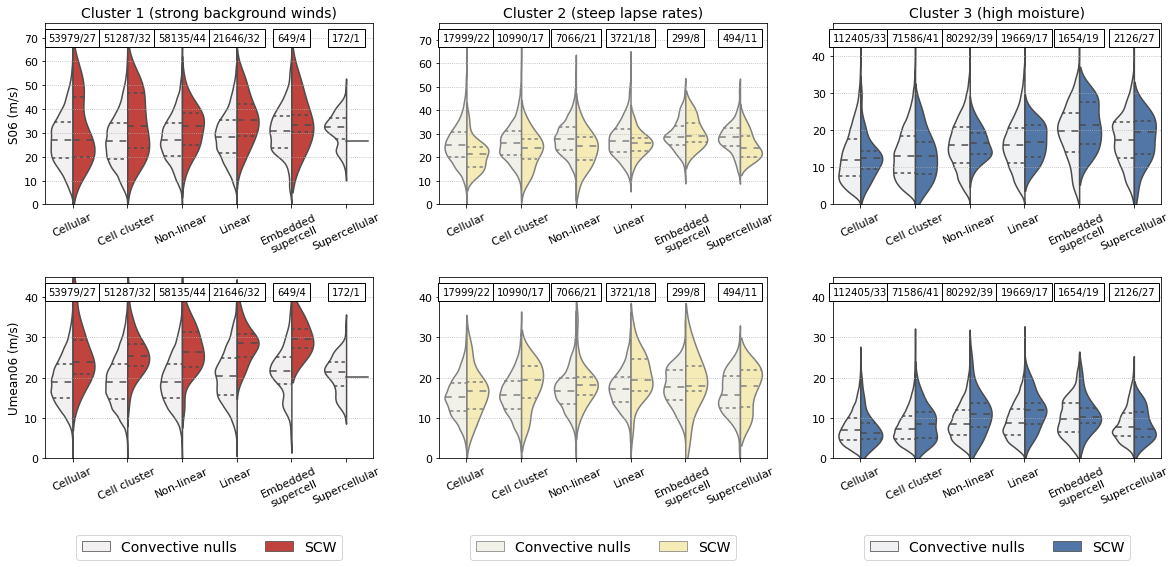

In [29]:
plt.figure(figsize=[20,8])
cnt=1
for v in ["s06","Umean06"]:
    for cluster in [0,1,2]:
        if v=="s06":
            title=True
        else:
            title=False
        if cluster==0:
            label=True
        else:
            label=False
        if v=="Umean06":
            legend=True
        else:
            legend=False
            
        plot_violin_split(df[[v,"cluster_new","scw","class2","in10km"]].query("in10km==1"),
                  v, cluster, order, plt.subplot(2,3,cnt), title=title, label=label, legend=legend)    
            
        cnt=cnt+1
        
plt.subplots_adjust(hspace=0.4)
        
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/storm_class_wind_dist.jpeg",dpi=400,bbox_inches="tight")        

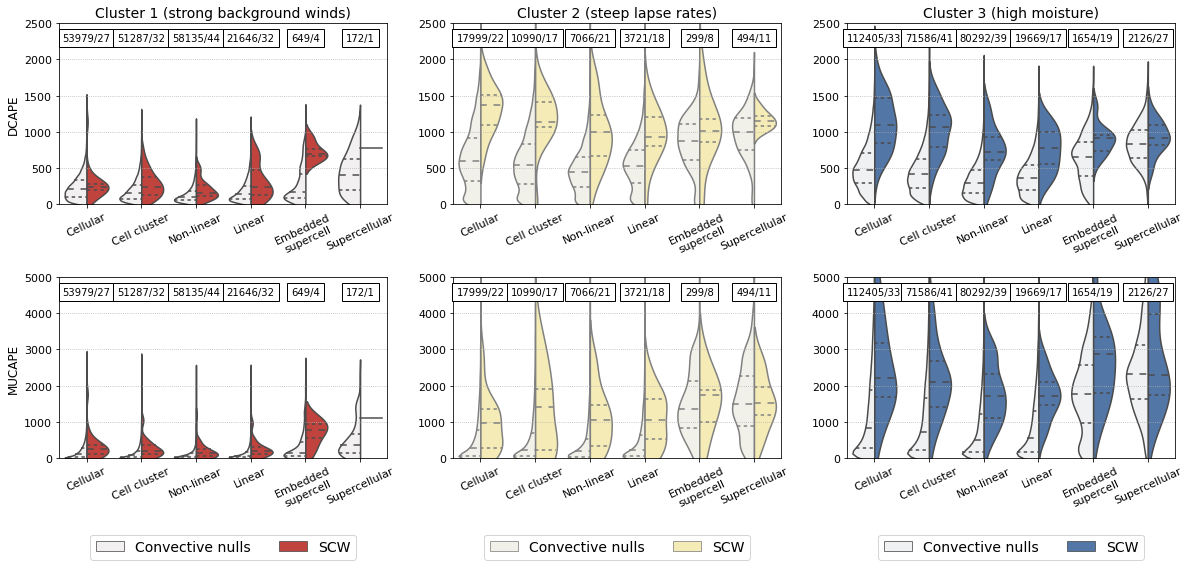

In [30]:
plt.figure(figsize=[20,8])
cnt=1
for v in ["dcape","mu_cape"]:
    for cluster in [0,1,2]:
        if v=="mu_cape":
            legend=True
        else:
            legend=False
        if cluster==0:
            label=True
        else:
            label=False
        if v == "dcape":
            title=True
        else:
            title=False
            
        plot_violin_split(df[[v,"cluster_new","scw","class2","in10km"]].query("in10km==1"),
                  v, cluster, order, plt.subplot(2,3,cnt), title=title, label=label, legend=legend)    
            
        cnt=cnt+1
        
plt.subplots_adjust(hspace=0.4)
        
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/storm_class_thermo_dist.jpeg",dpi=400,bbox_inches="tight")        

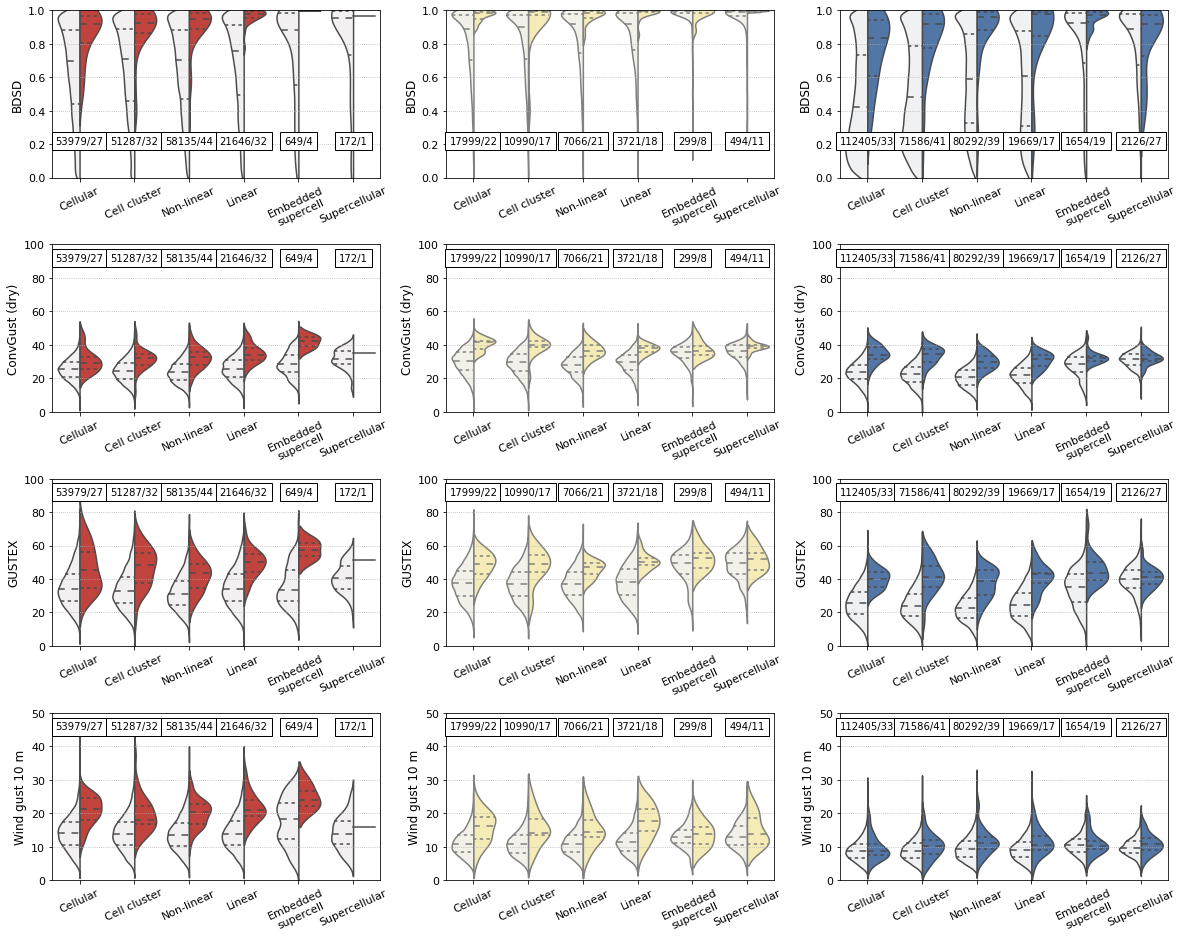

In [31]:
plt.figure(figsize=[20,16])
cnt=1
for v in ["bdsd","convgust_dry","gustex","wg10"]:
    for cluster in [0,1,2]:
        legend=False
        label=True
        if v == "bdsd":
            plot_violin_split(df[[v,"cluster_new","scw","class2","in10km"]].query("in10km==1"),
                      v, cluster, order, plt.subplot(4,3,cnt), title=title, label=label, legend=legend, sample_size="bottom")                
        else:
            plot_violin_split(df[[v,"cluster_new","scw","class2","in10km"]].query("in10km==1"),
                      v, cluster, order, plt.subplot(4,3,cnt), title=title, label=label, legend=legend)    
            
        cnt=cnt+1
        
plt.subplots_adjust(hspace=0.4)
        

1
2
3
4
5
6
7
8
9
10
11
12


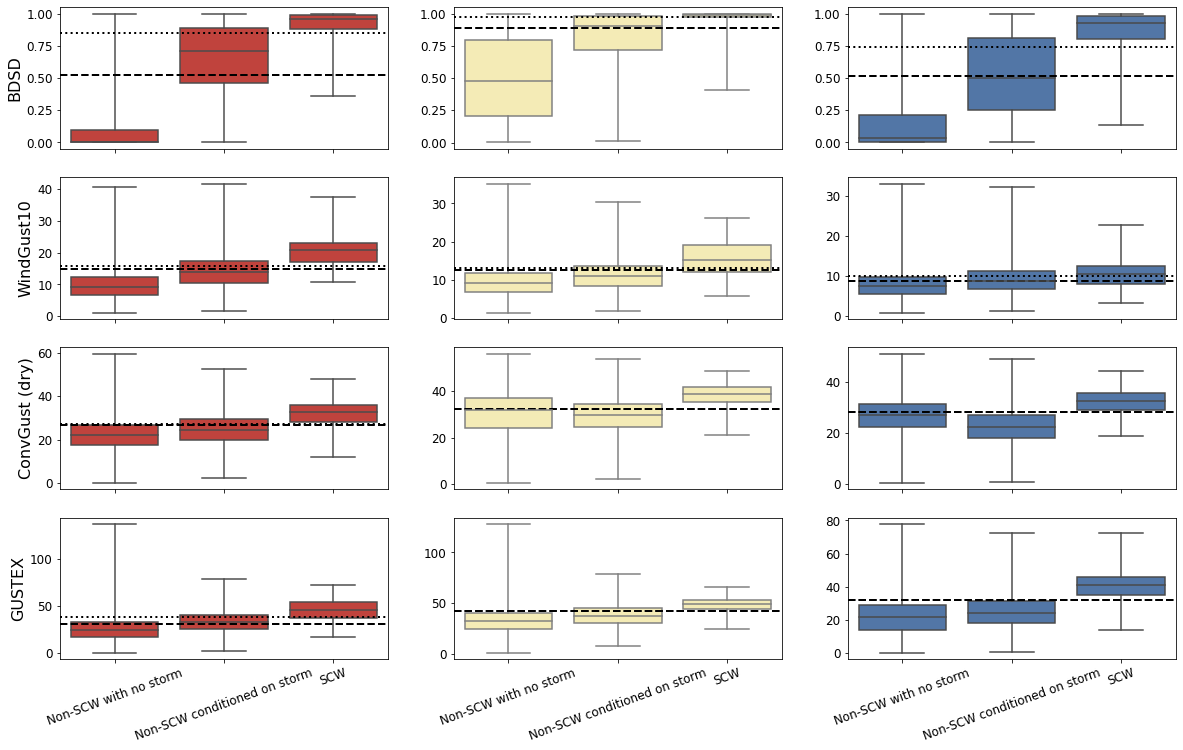

In [32]:
plt.figure(figsize=[20,12])

cnt=0
labels = {"bdsd":"BDSD", "wg10":"WindGust10", "convgust_dry":"ConvGust (dry)","gustex":"GUSTEX"}
for v in ["bdsd","wg10","convgust_dry","gustex"]:
    for c in [0,1,2]:
        print((cnt*3) + (c+1))
        ax=plt.subplot(4,3,(cnt*3) + (c+1))    
        x1 = df[[v,"cluster_new","scw","in10km"]].query("(cluster_new=="+str(c)+") & (in10km==0)")[v]
        x2 = df[[v,"cluster_new","scw","in10km"]].query("(cluster_new=="+str(c)+") & (in10km==1) & (scw==0)")[v]
        x3 = df[[v,"cluster_new","scw","in10km"]].query("(cluster_new=="+str(c)+") & (in10km==1) & (scw==1)")[v]
        #sns.violinplot(data=[x1,x2,x3],inner="quartile",color=p[c],ax=ax)
        sns.boxplot(data=[x1,x2,x3],color=p[c],ax=ax,whis=1e10)
        
        if v == "gustex":
            plt.xticks([0,1,2],["Non-SCW with no storm","Non-SCW conditioned on storm","SCW"],rotation=20)
        else:
            plt.xticks([0,1,2],["","",""])

        ax.axhline(pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster"+str(c+1)+"_in10km.csv")[v].median(), color="k", ls=":",lw=2)
        ax.axhline(pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster"+str(c+1)+".csv")[v].median(), color="k", ls="--",lw=2)

        ax.tick_params(labelsize=12)
        
        if c == 0:
            ax.set_ylabel(labels[v],size=16)
    cnt=cnt+1

2
66
69
70
71
64
8
72
75
19
73
78
49
4
40
48
68
63
76
77


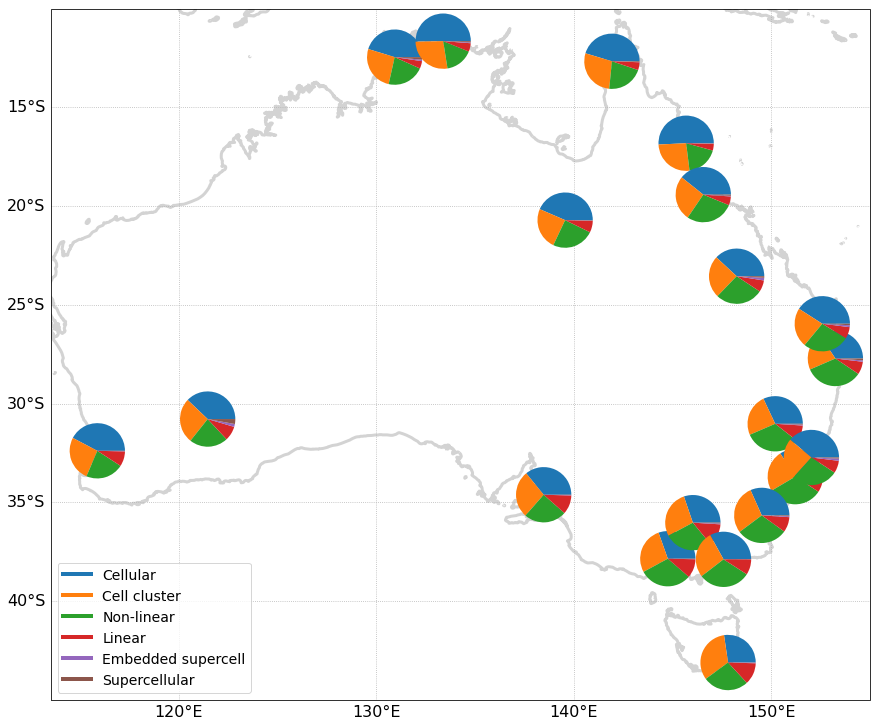

In [33]:
fig=plt.figure(figsize=[16,12])

order = ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]

ax0 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="lightgray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for rid in rids:
    print(rid)
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]   

    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)
    
    width_height = 0.1
    
    ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                        width_height,width_height),anchor="C")
    ax1.pie([df[(df.class2==o) & (df.in10km==1) & (df.rid==rid)].shape[0] for o in order])


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4),
                Line2D([0], [0], color="tab:orange", lw=4),
                Line2D([0], [0], color="tab:green", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="tab:purple", lw=4),
                Line2D([0], [0], color="tab:brown", lw=4)]
plt.legend(custom_lines, order, fontsize=14,loc=3)    
    

In [14]:
def event_prob(df, cluster):     

    if cluster>=0:
    
        non_events = df[["cluster_new","scw"]][(df["cluster_new"]==cluster)].shape[0]
        events = df[["cluster_new","scw"]][(df["cluster_new"]==cluster) & (df["scw"]==1)].shape[0]        
        print("Cluster ",cluster," event probability: ",np.round(((events/non_events)*100),3),"%")

        non_events = df[["cluster_new","scw","in10km"]][(df["cluster_new"]==cluster) & (df["in10km"]==1)].shape[0]
        events = df[["cluster_new","scw","in10km"]][(df["cluster_new"]==cluster) & (df["scw"]==1) & (df["in10km"]==1)].shape[0] 
        print("Cluster ",cluster," event probability (conditioned on storm): ",np.round(((events/non_events)*100),3),"%")          
        
    else:
        
        non_events = df[["scw"]].shape[0]
        events = df[["scw"]][(df["scw"]==1)].shape[0]        
        print("All clusters event probability: ",np.round(((events/non_events)*100),3),"%")

        non_events = df[["scw","in10km"]][(df["in10km"]==1)].shape[0]
        events = df[["scw","in10km"]][(df["scw"]==1) & (df["in10km"]==1)].shape[0] 
        print("All clusters event probability (conditioned on storm): ",np.round(((events/non_events)*100),3),"%")                  

event_prob(df,cluster=-1)

print("\n")
event_prob(df,cluster=0)

print("\n")
event_prob(df,cluster=1)

print("\n")
event_prob(df,cluster=2)


All clusters event probability:  0.003 %
All clusters event probability (conditioned on storm):  0.08 %


Cluster  0  event probability:  0.003 %
Cluster  0  event probability (conditioned on storm):  0.075 %


Cluster  1  event probability:  0.012 %
Cluster  1  event probability (conditioned on storm):  0.239 %


Cluster  2  event probability:  0.003 %
Cluster  2  event probability (conditioned on storm):  0.061 %


In [35]:
def lightning_prob(df, cluster):     

    temp = df[["cluster_new","scw","Lightning_observed"]]
    
    if cluster>=0:
    
        events_lightning = temp[(df["cluster_new"]==cluster) & (df["scw"]==1) & (df["Lightning_observed"]>=1)].shape[0]
        print("Cluster ",cluster," event lightning probability: ",
              np.round(((events_lightning/temp[temp["cluster_new"]==cluster].scw.sum())*100),1),"%")

        conv_nulls_lightning = temp[(df["cluster_new"]==cluster) & (df["Lightning_observed"]>=1) & (df["scw"]==0) & (df["in10km"]==1)].shape[0]
        print("Cluster ",cluster," total lightning probability: ",
              np.round(((conv_nulls_lightning/(temp[(temp["cluster_new"]==cluster) & (temp["scw"]==0) & (df["in10km"]==1)].shape[0]))*100),1),"%")         
        
        non_events_lightning = temp[(df["cluster_new"]==cluster) & (df["Lightning_observed"]>=1) & (df["scw"]==0)].shape[0]
        print("Cluster ",cluster," total lightning probability: ",
              np.round(((non_events_lightning/(temp[(temp["cluster_new"]==cluster) & (temp["scw"]==0)].shape[0]))*100),1),"%")             
    
    else:
    
        events_lightning = temp[(df["scw"]==1) & (df["Lightning_observed"]>=1)].shape[0]
        print("All clusters event lightning probability: ",
              np.round(((events_lightning/temp.scw.sum())*100),1),"%")

        conv_nulls_lightning = temp[(df["Lightning_observed"]>=1) & (df["scw"]==0) & (df["in10km"]==1)].shape[0]
        print("All clusters total lightning probability: ",
              np.round(((conv_nulls_lightning/(temp[(temp["scw"]==0) & (df["in10km"]==1)].shape[0]))*100),1),"%")         
        
        non_events_lightning = temp[(df["Lightning_observed"]>=1) & (df["scw"]==0)].shape[0]
        print("All clusters total lightning probability: ",
            np.round(((non_events_lightning/(temp[(temp["scw"]==0)].shape[0]))*100),1),"%")                     
    
    del temp

    
lightning_prob(df,cluster=-1)    
    
print("\n")
lightning_prob(df,cluster=0)

print("\n")
lightning_prob(df,cluster=1)

print("\n")
lightning_prob(df,cluster=2)


All clusters event lightning probability:  69.0 %
All clusters total lightning probability:  23.0 %
All clusters total lightning probability:  2.5 %


Cluster  0  event lightning probability:  27.1 %
Cluster  0  total lightning probability:  7.4 %
Cluster  0  total lightning probability:  0.5 %


Cluster  1  event lightning probability:  80.4 %
Cluster  1  total lightning probability:  30.8 %
Cluster  1  total lightning probability:  3.4 %


Cluster  2  event lightning probability:  96.0 %
Cluster  2  total lightning probability:  32.0 %
Cluster  2  total lightning probability:  4.2 %


In [36]:
#Look at the variability in diagnostics compared to observed variability. Do this for most skilful diagnostic in each cluser, conditional on a storm, 
# and unconditional on a storm. BDSD, WG10, GUSTEX, CONVGUST (dry).

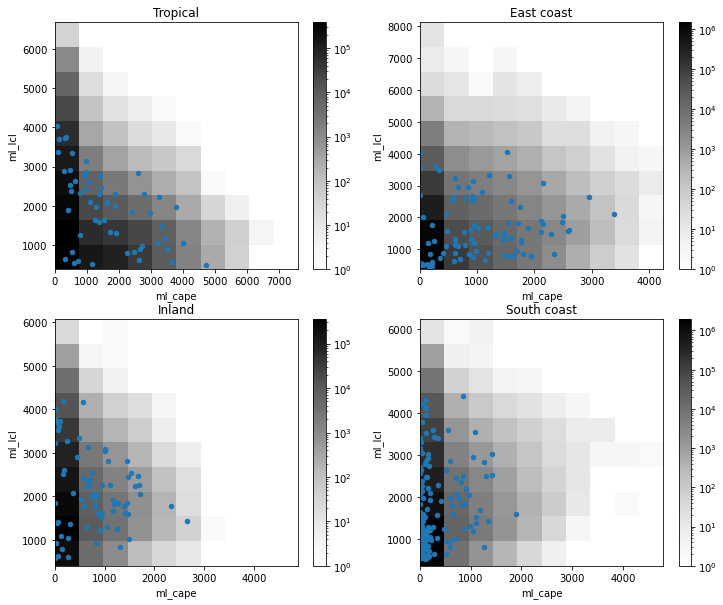

In [37]:
import matplotlib

plt.figure(figsize=[12,10])
cnt=1
x="ml_cape"
y="ml_lcl"
for rid_list,list_name in zip([tropical_rids,east_coast_rids,inland_rids,south_coast_rids],["Tropical","East coast","Inland","South coast"]):

    ax=plt.subplot(2,2,cnt)

    temp = df[["scw","rid",x,y]]
    h=plt.hist2d(temp[np.in1d(temp.rid,rid_list)][x].values,temp[np.in1d(temp.rid,rid_list)][y].values,norm=matplotlib.colors.LogNorm(),cmap="Greys")
    plt.colorbar()    
    temp[np.in1d(temp.rid,rid_list)].query("scw==1").plot(kind="scatter",x=x,y=y,ax=ax)
    plt.title(list_name)
    cnt=cnt+1

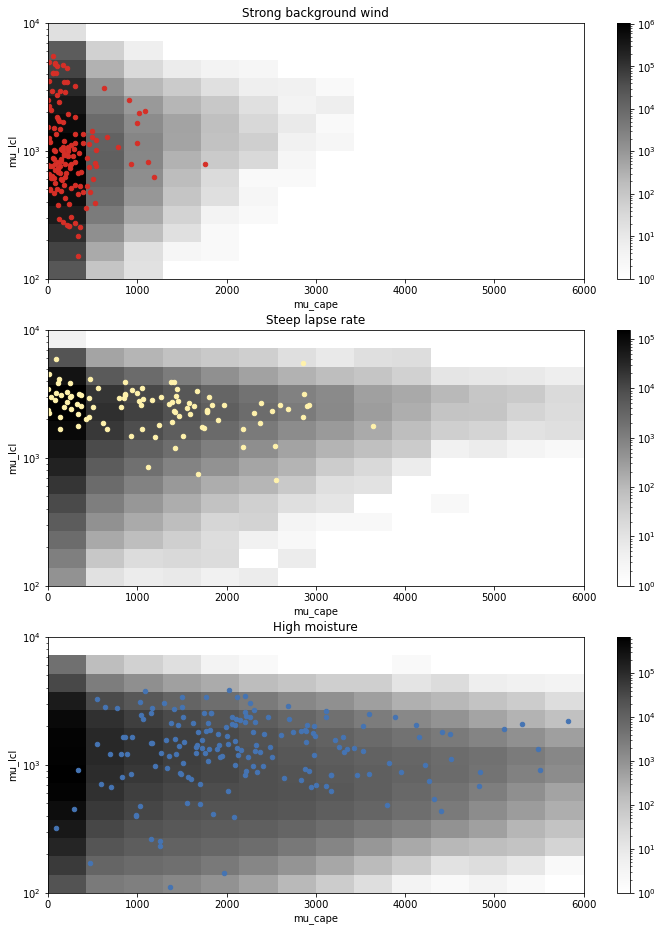

In [38]:
plt.figure(figsize=[12,16])
cnt=1
x="mu_cape"
y="mu_lcl"

for c,c_name in zip([0,1,2],["Strong background wind","Steep lapse rate","High moisture"]):

    ax=plt.subplot(3,1,cnt)
    plt.yscale("log")
    
    temp = df[["scw","cluster_new",x,y]]
    h=plt.hist2d(temp[np.in1d(temp.cluster_new,[c])][x].values,temp[np.in1d(temp.cluster_new,[c])][y].values,norm=matplotlib.colors.LogNorm(),cmap="Greys",
                bins=[np.linspace(0,6000,15),np.logspace(2,4,15)])
#                range=[[100,6000],[100,6000]])
    plt.colorbar()    
    temp[np.in1d(temp.cluster_new,[c])].query("scw==1").plot(kind="scatter",x=x,y=y,ax=ax,color=p[c])
    plt.title(c_name)

    
    cnt=cnt+1

In [39]:
def interp_roc(x, fpr, tpr, thresholds):
    return np.interp(x, np.flip(thresholds), np.flip(fpr)), np.interp(x, np.flip(thresholds), np.flip(tpr))

def plot_roc(ax, df, opt_tss, cmap, letter, title):

    RocCurveDisplay.from_predictions(df["scw"],df["bdsd"],ax=ax)
    fpr, tpr, thresholds = roc_curve(df["scw"],df["bdsd"])
    for t in [0.0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0]:
        x, y = interp_roc(t, fpr, tpr, thresholds)
        ax.plot(x, y, marker="o",label='%.2f' % (t), color=cmap(t), mec="k", ls="none", ms=10)
    opt_tss_x, opt_tss_y = interp_roc(opt_tss, fpr, tpr, thresholds)
    #ax.plot([0.5,opt_tss_x], [0.5,opt_tss_y], color="k", ls="--", label="Optimal TSS")
    ax.plot([opt_tss_x], [opt_tss_y], color=cmap(1.0), mec="k", label="Optimal TSS\nthreshold ("+str(np.round(opt_tss,2))+")", ms=18, marker="^", ls="none")
    # opt_csi_x, opt_csi_y = interp_roc(opt_csi, fpr, tpr, thresholds)
    # ax.plot([0.5,opt_csi_x], [0.5,opt_csi_y], color="tab:red", ls="--",label="Optimal CSI")         
    plt.legend(fontsize=12,ncol=2,loc=4)
    ax.plot([0,1],[0,1],color="k",ls=":")
    ax.grid(ls=":")
    ax.set_ylabel("Hit rate",size=16)
    ax.set_xlabel("False alarm rate",size=16)
    ax.tick_params("both",labelsize=14)
    ax.set_xticks(np.arange(0,1.1,.1))
    ax.set_yticks(np.arange(0,1.1,.1)) 
    ax.text(0.05,0.92,letter+")",size=18,transform=ax.transAxes)
    ax.set_title(title,size=20)
    

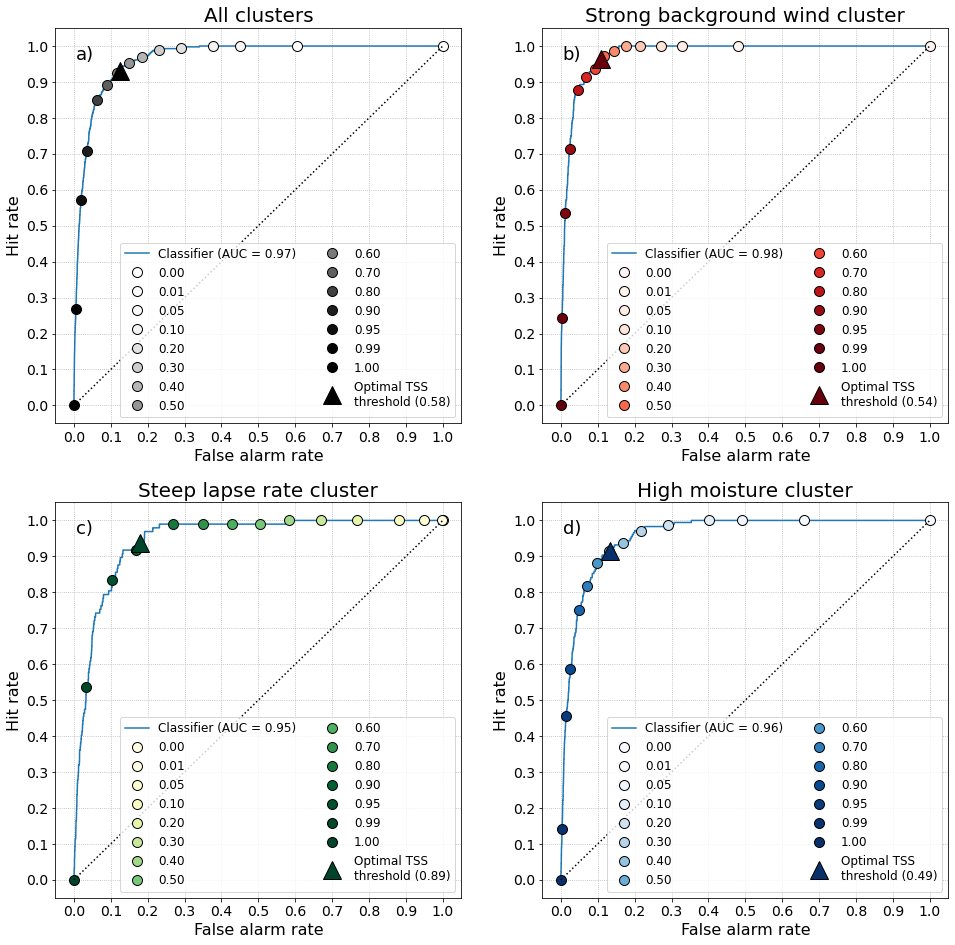

In [40]:
tss_thresh = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_clusterall.csv")
tss_thresh1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster1.csv")
tss_thresh2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster2.csv")
tss_thresh3 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster3.csv")

plt.figure(figsize=[16,16])
plot_roc(plt.subplot(2,2,1), df[["scw","bdsd"]], tss_thresh.bdsd.mean(), plt.get_cmap("Greys"), "a", "All clusters")
plot_roc(plt.subplot(2,2,2), df[["scw","bdsd","cluster_new"]].query("cluster_new==0"), tss_thresh1.bdsd.mean(), plt.get_cmap("Reds"), "b", "Strong background wind cluster")
plot_roc(plt.subplot(2,2,3), df[["scw","bdsd","cluster_new"]].query("cluster_new==1"), tss_thresh2.bdsd.mean(), plt.get_cmap("YlGn"), "c", "Steep lapse rate cluster")
plot_roc(plt.subplot(2,2,4), df[["scw","bdsd","cluster_new"]].query("cluster_new==2"), tss_thresh3.bdsd.mean(), plt.get_cmap("Blues"), "d", "High moisture cluster")
     
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/skill_roc.jpeg",bbox_inches="tight",dpi=500)    

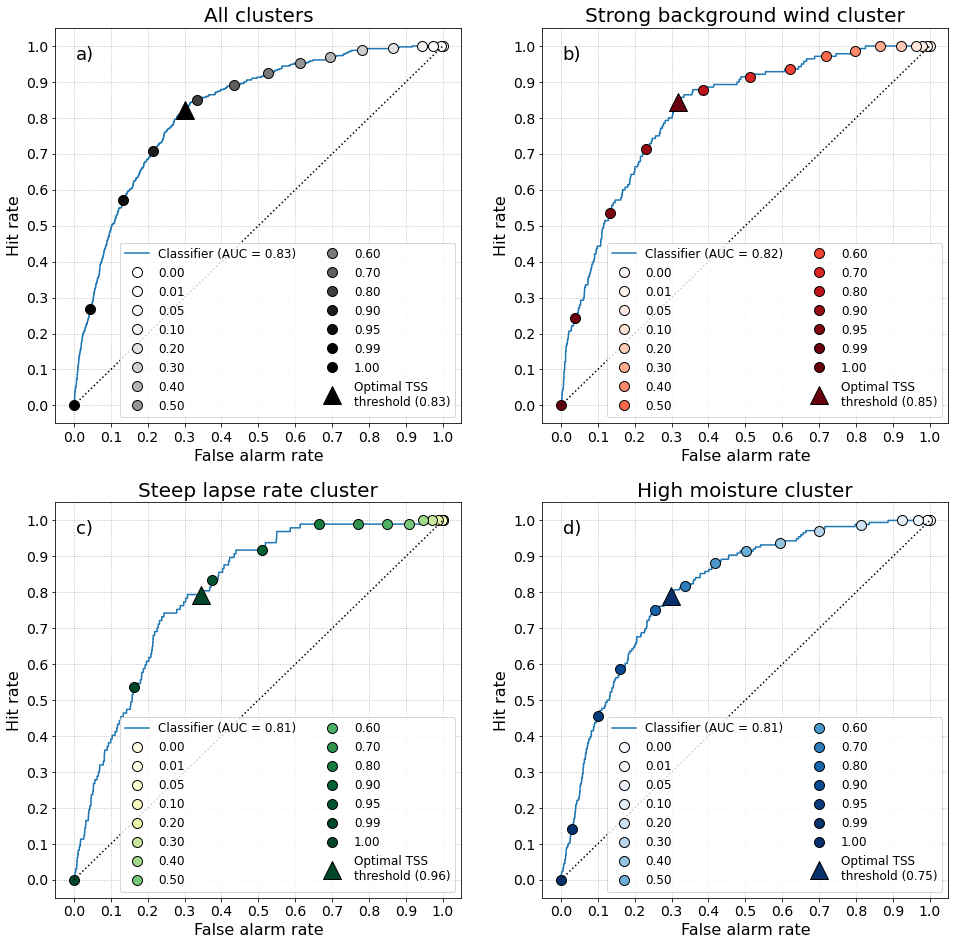

In [41]:
tss_thresh = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_clusterall_in10km.csv")
tss_thresh1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster1_in10km.csv")
tss_thresh2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster2_in10km.csv")
tss_thresh3 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/skill_scores/tss_thresh_era5_cluster3_in10km.csv")

plt.figure(figsize=[16,16])
plot_roc(plt.subplot(2,2,1), df[["scw","bdsd","in10km"]].query("in10km==1"), tss_thresh.bdsd.mean(), plt.get_cmap("Greys"), "a", "All clusters")
plot_roc(plt.subplot(2,2,2), df[["scw","bdsd","cluster_new","in10km"]].query("(cluster_new==0) & (in10km==1)"), tss_thresh1.bdsd.mean(), plt.get_cmap("Reds"), "b", "Strong background wind cluster")
plot_roc(plt.subplot(2,2,3), df[["scw","bdsd","cluster_new","in10km"]].query("(cluster_new==1) & (in10km==1)"), tss_thresh2.bdsd.mean(), plt.get_cmap("YlGn"), "c", "Steep lapse rate cluster")
plot_roc(plt.subplot(2,2,4), df[["scw","bdsd","cluster_new","in10km"]].query("(cluster_new==2) & (in10km==1)"), tss_thresh3.bdsd.mean(), plt.get_cmap("Blues"), "d", "High moisture cluster")
     

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/skill_roc_in10km.jpeg",bbox_inches="tight",dpi=500)